In [3]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
global g, d, m, i, v15, P0, T0, w, zt, cd, m3, S, Tv, Tz, v0
g = 9.80665 #ускорение свободного падения
d = 12.7 * 10**-3 #диаметр пули
m = 48.3 * 10**-3 #масса пули
i = 1.0629 #коэффиециен формы
v15 = 820.0 #начальная скорость пули T = 15 c
P0 = 750 #начальное давление
T0 = 15 #начальная температура
w = 0.5 #влажность воздуха
zt = 1.35 * 10**-3 #коэффиециент температуры заряда
cd = 0.0423 #коэффиециент деривации
m3 = 0.1744 #коэффиециент убывания угловой скорости
S = pi*d*d/4
Tv = (T0 + 273.15)/(1 - 3*12.7/(8.0*P0) * w)

def T(y):
    global Tv
    return Tv - 0.0065*y

def p(y):
    global Tv,P0
    return 1.225 * np.power(T(y)/Tv, 4.256) * P0*288.15/(Tv*760.0)

def s_speed(y):
    return 340.294 * (T(y)/288.15)**(1/2.0)

def cx(x):
    pa = np.array([0.0525, -0.9476, 8.9342, -9.4610, 0.3207, 4.2980, -1.9382])
    pb = np.array([1.0000, -15.4071, 178.6690, -580.8643, 985.5873, -853.9492, 296.9213])
    pc = np.array([0.0531, 0.9449, 90.5063, 0.1639])
    return np.polyval(pa,x**2)/np.polyval(pb,x**2) + pc[0] / (1+np.exp(-(x-pc[1])*pc[2]))+pc[3]

Tz = T0
v0 = v15*(1+zt*(Tz-15))

def Fs(i,S,p,v,a):
    return i*S*p*v*v/2*cx(v/a)

In [5]:
butcher = [np.array([0, 0, 0, 0, 0, 0, 0], dtype=np.longdouble), 
           np.array([4/7, 0, 0, 0, 0, 0, 0], dtype=np.longdouble), 
           np.array([115/112, -5/16, 0, 0, 0, 0, 0], dtype=np.longdouble), 
           np.array([589/630, 5/18, -16/45, 0, 0, 0, 0], dtype=np.longdouble),
           np.array([229/1200-29/6000*5**0.5, 119/240-187/1200*5**0.5, -14/75+34/375*5**0.5, -3/100*5**0.5, 0, 0, 0], dtype=np.longdouble),
           np.array([71/2400-587/12000*5**0.5, 187/480-391/2400*5**0.5, -38/75+26/375*5**0.5, 27/80-3/400*5**0.5, (1+5**0.5)/4, 0, 0], dtype=np.longdouble),
           np.array([-49/480+43/160*5**0.5, -425/96+51/32*5**0.5, 52/15-4/5*5**0.5, -27/16+3/16*5**0.5, 5/4-3/4*5**0.5, 5/2-0.5*5**0.5, 0], dtype=np.longdouble) 
          ]
a = np.array([0, 4/7, 5/7, 6/7, (5-5**0.5)/10, (5+5**0.5)/10, 1],dtype=np.longdouble)
b = np.array([1/12, 0, 0, 0, 5/12, 5/12, 1/12], dtype=np.longdouble)

butcher = [[0, 0, 0, 0], [0.5, 0, 0, 0], [0, 0.5, 0, 0], [0, 0, 1, 0]]
a = np.matrix('0; 0.5; 0.5; 1')
v = 1/6
b = np.matrix([[v], [2*v], [2*v], [v]])

In [6]:
def mult(vect,list_):
    res = np.matrix(np.zeros(vect[0].shape))
    for v,l in zip(vect,list_):
        res = res + v*l
    return res
def universal_runge_kutta(f ,u0, t, butcher, a, b):
    u = np.array([u0] * len(t))
    w = [np.matrix(np.zeros(u0.shape))] * len(butcher)
    for i,ui in enumerate(u[:-1]):
        tau = t[i+1] - t[i]
        for j,wj in enumerate(w):
            w[j] = f(u[i] + tau * mult(w, butcher[j]), t[i] + tau * a[j])
        u[i+1] = u[i] + tau * mult(w,b)
    return u, t
def f(ui, x):
    #print(ui,'\n')
    global m, g, i, S
    u = ui[0].item(0)
    gamma = ui[1].item(0)
    y = ui[2].item(0)
    t = ui[3].item(0)
    v = u * np.sqrt(1+gamma**2)
    return np.matrix([
    [-Fs(i, S, p(y), v, s_speed(y)) / (m*v)],
    [-g/u**2],
    [gamma],
    [1/u]
    ])

print('T0 = 15\n')
theta0 = pi/300
theta1 = pi/50
eps = 10**-15
n = 0 
while True:
    print("iteration",n)
    theta = (theta0+theta1)/2
    print(theta)
    u0 = np.array([          
        [v0*np.cos(theta)], #u
        [np.tan(theta)],    #gamma
        [0.0],              #y
        [0.0]               #t
        ])
    ans = universal_runge_kutta(f, u0, np.linspace(0,2000,16), butcher, a, b)[0][-1][2].item(0)
    print(ans)
    if abs(ans) < 10**-5:
        break
    if ans > 0:
        theta1 = theta
    else:
        theta0 = theta
    n+=1
theta*180/pi/0.06

In [7]:
print('T0 = 15\n')
theta0 = 0.01
theta1 = 0.03
eps = 10**-15
n = 0 
while abs(theta1 - theta0) > eps:
    print("iteration",n)
    print(abs(theta1 - theta0))
    u0 = np.array([          
        [v0*np.cos(theta1)], #u
        [np.tan(theta1)],   #gamma
        [0.0],                 #y
        [0.0]                  #t
        ])
    ans1 = universal_runge_kutta(f, u0, np.linspace(0,2000,8), butcher, a, b)
    
    u0 = np.array([          
        [v0*np.cos(theta0)],   #u
        [np.tan(theta0)],      #gamma
        [0.0],                 #y
        [0.0]                  #t
        ])
    ans0 = universal_runge_kutta(f, u0, np.linspace(0,2000,8), butcher, a, b)
    new_theta = theta1 - (theta1 - theta0) * ans1[0][-1][2].item(0) / (ans1[0][-1][2].item(0) - ans0[0][-1][2].item(0))
    theta0 = theta1
    theta1 = new_theta
    n+=1
theta1*180/pi/0.06

T0 = 15

iteration 0
0.019999999999999997
iteration 1
0.005527825819328758
iteration 2
4.0500266431584e-06
iteration 3
4.514686541279289e-10


33.93044250040451

In [8]:
global g, d, m, i, v15, P0, T0, w, zt, cd, m3, S, Tv, Tz, v0
g = 9.80665 #ускорение свободного падения
d = 12.7 * 10**-3 #диаметр пули
m = 48.3 * 10**-3 #масса пули
i = 1.0629 #коэффиециен формы
v15 = 820.0 #начальная скорость пули T = 15 c
P0 = 750 #начальное давление
T0 = 5 #начальная температура
w = 0.5 #влажность воздуха
zt = 1.35 * 10**-3 #коэффиециент температуры заряда
cd = 0.0423 #коэффиециент деривации
m3 = 0.1744 #коэффиециент убывания угловой скорости
S = pi*d*d/4
Tv = (T0 + 273.15)/(1 - 3*12.7/(8.0*P0) * w)

def T(y):
    global Tv
    return Tv - 0.0065*y

def p(y):
    global Tv,P0
    return 1.225 * np.power(T(y)/Tv, 4.256) * P0*288.15/(Tv*760.0)

def s_speed(y):
    return 340.294 * (T(y)/288.15)**(1/2.0)

def cx(x):
    pa = np.array([0.0525, -0.9476, 8.9342, -9.4610, 0.3207, 4.2980, -1.9382])
    pb = np.array([1.0000, -15.4071, 178.6690, -580.8643, 985.5873, -853.9492, 296.9213])
    pc = np.array([0.0531, 0.9449, 90.5063, 0.1639])
    return np.polyval(pa,x**2)/np.polyval(pb,x**2) + pc[0] / (1+np.exp(-(x-pc[1])*pc[2]))+pc[3]

Tz = T0
v0 = v15*(1+zt*(Tz-15))

def Fs(i,S,p,v,a):
    return i*S*p*v*v/2*cx(v/a)

print('T0 = 5\n')
T0 = 5
theta0 = 0.01
theta1 = 0.1
eps = 10**-15
n = 0 
while abs(theta1 - theta0) > eps:
    print("iteration",n)
    print(abs(theta1 - theta0))
    u0 = np.array([          
        [v0*np.cos(theta1)], #u
        [np.tan(theta1)],   #gamma
        [0.0],                 #y
        [0.0]                  #t
        ])
    ans1 = universal_runge_kutta(f, u0, np.linspace(0,2000,8), butcher, a, b)
    
    u0 = np.array([          
        [v0*np.cos(theta0)],   #u
        [np.tan(theta0)],      #gamma
        [0.0],                 #y
        [0.0]                  #t
        ])
    ans0 = universal_runge_kutta(f, u0, np.linspace(0,2000,8), butcher, a, b)
    new_theta = theta1 - (theta1 - theta0) * ans1[0][-1][2].item(0) / (ans1[0][-1][2].item(0) - ans0[0][-1][2].item(0))
    theta0 = theta1
    theta1 = new_theta
    n+=1
theta1*180/pi/0.06

T0 = 5

iteration 0
0.09000000000000001
iteration 1
0.06213691282389146
iteration 2
1.5325823330733512e-05
iteration 3
4.0579831162013136e-10


36.141949438033194

In [9]:
global g, d, m, i, v15, P0, T0, w, zt, cd, m3, S, Tv, Tz, v0, V
g = 9.80665 #ускорение свободного падения
d = 12.7 * 10**-3 #диаметр пули
m = 48.3 * 10**-3 #масса пули
i = 1.0629 #коэффиециен формы
v15 = 820.0 #начальная скорость пули T = 15 c
P0 = 750 #начальное давление
T0 = 15 #начальная температура
w = 0.5 #влажность воздуха
zt = 1.35 * 10**-3 #коэффиециент температуры заряда
cd = 0.0423 #коэффиециент деривации
m3 = 0.1744 #коэффиециент убывания угловой скорости
S = pi*d*d/4
V = -10
Tv = (T0 + 273.15)/(1 - 3*12.7/(8.0*P0) * w)

def T(y):
    global Tv
    return Tv - 0.0065*y

def p(y):
    global Tv,P0
    return 1.225 * np.power(T(y)/Tv, 4.256) * P0*288.15/(Tv*760.0)

def s_speed(y):
    return 340.294 * (T(y)/288.15)**(1/2.0)

def cx(x):
    pa = np.array([0.0525, -0.9476, 8.9342, -9.4610, 0.3207, 4.2980, -1.9382])
    pb = np.array([1.0000, -15.4071, 178.6690, -580.8643, 985.5873, -853.9492, 296.9213])
    pc = np.array([0.0531, 0.9449, 90.5063, 0.1639])
    return np.polyval(pa,x**2)/np.polyval(pb,x**2) + pc[0] / (1+np.exp(-(x-pc[1])*pc[2]))+pc[3]

Tz = T0
v0 = v15*(1+zt*(Tz-15))

def Fs(i,S,p,v,a):
    return i*S*p*v*v/2*cx(v/a)

def f(ui, x):
    global m, g, i, S, cd, m3,V
    u = ui[0].item(0)
    gamma = ui[1].item(0)
    y = ui[2].item(0)
    t = ui[3].item(0)
    z = ui[4].item(0)
    q = ui[5].item(0)
    v = u * np.sqrt(1+gamma**2)
    return np.matrix([
    [-Fs(i, S, p(y), v, s_speed(y)) / (m*v)],
    [-g/u**2],
    [gamma],
    [1/u],
    [q*pi*v0*cd+V/u],
    [np.exp(-m3*t)/(v**2*u)]
    ])

theta = 0.01
alpha = pi/4

def NewtonSolver(f, u0, eps=10**-12, h = 10**-5):
    u = u0
    dx = np.matrix(np.ones(u0.shape))
    i = 0
    fu = np.zeros( (u0.shape[0], u0.shape[0]) )
    while abs(min(dx).item(0)) > eps :
        print("Iteration:", i)
        i+=1
        du = np.matrix(np.zeros(u0.shape), dtype = np.float64)
        for j in range( u0.shape[0] ):
            du[j-1] = 0 
            du[j] = h
            val = ( f(u+du) - f(u-du) )/(2*h)
            for k in range( u0.shape[0] ):
                fu[j][k]= val[k] 
        fu = fu.T
        dx = -1 * np.linalg.inv(fu) * f(u)
        u = u + dx
    return u

def newton_f(u):
    global v0
    theta = u[0].item(0)
    alpha = u[1].item(0)
    u0 = np.array([          
        [v0*np.cos(theta)], #u
        [np.tan(theta)],   #gamma
        [0.0],                 #y
        [0.0],                  #t
        [0.0],                 #z
        [np.sin(alpha)]        #q
        ])
    ans0 = universal_runge_kutta(f, u0, np.linspace(0,2000,8), butcher, a, b)
    return np.matrix( [[ans0[0][-1][2].item(0)],[ans0[0][-1][4].item(0)]])

res = NewtonSolver(newton_f, np.matrix( [[theta],[alpha]]))
res*=180/pi/0.06
print('Theta:', res[0].item(0))
print('Alpha:', res[1].item(0))

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Theta: 33.93044250040452
Alpha: 0.19036621162672127


In [13]:
import math
global g, d, m, i, v15, P0, T0, w, zt, cd, m3, S, Tv, Tz, v0
g = 9.80665 #ускорение свободного падения
d = 12.7 * 10**-3 #диаметр пули
m = 48.3 * 10**-3 #масса пули
i = 1.0629 #коэффиециен формы
v15 = 820.0 #начальная скорость пули T = 15 c
P0 = 750 #начальное давление
T0 = 5 #начальная температура
w = 0.5 #влажность воздуха
zt = 1.35 * 10**-3 #коэффиециент температуры заряда
cd = 0.0423 #коэффиециент деривации
m3 = 0.1744 #коэффиециент убывания угловой скорости
S = pi*d*d/4
Tv = (T0 + 273.15)/(1 - 3*12.7/(8.0*P0) * w)

def T(y):
    global Tv
    return Tv - 0.0065*y

def p(y):
    global Tv,P0
    return 1.225 * np.power(T(y)/Tv, 4.256) * P0*288.15/(Tv*760.0)

def s_speed(y):
    return 340.294 * (T(y)/288.15)**(1/2.0)

def cx(x):
    pa = np.array([0.0525, -0.9476, 8.9342, -9.4610, 0.3207, 4.2980, -1.9382])
    pb = np.array([1.0000, -15.4071, 178.6690, -580.8643, 985.5873, -853.9492, 296.9213])
    pc = np.array([0.0531, 0.9449, 90.5063, 0.1639])
    return np.polyval(pa,x**2)/np.polyval(pb,x**2) + pc[0] / (1+np.exp(-(x-pc[1])*pc[2]))+pc[3]

Tz = T0
v0 = v15*(1+zt*(Tz-15))

def Fs(i,S,p,v,a):
    return i*S*p*v*v/2*cx(v/a)

def f(ui, x):
    #print(ui,'\n')
    global m, g, i, S
    u = ui[0].item(0)
    gamma = ui[1].item(0)
    y = ui[2].item(0)
    t = ui[3].item(0)
    v = u * np.sqrt(1+gamma**2)
    return np.matrix([
    [-Fs(i, S, p(y), v, s_speed(y)) / (m*v)],
    [-g/u**2],
    [gamma],
    [1/u]
    ])


x = np.linspace(0.0001,8000,256)
phi = np.linspace(0.0001,pi/2-0.0001,60)
dist = []
for theta in phi:
    u0 = np.array([          
        [v0*np.cos(theta)],    #u
        [np.tan(theta)],       #gamma
        [0.0],                 #y
        [0.0]                  #t
        ])
    ans0 = universal_runge_kutta(f, u0, x, butcher, a, b)
    arr = [n[2].item(0)>=0 for n in ans0[0]].index(False)
    dist.append(x[arr-1])

D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
D:\Programs\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:680: RuntimeWarning: overflow encountered in double_scalars
  y = y * x + p[i]
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in power
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in cdouble_scalars
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in cdouble_scalars
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the i

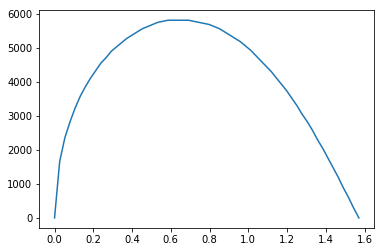

In [14]:
plt.figure()
plt.plot(phi,dist)

In [15]:
max(dist)

5803.921596078431

D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
D:\Programs\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:680: RuntimeWarning: overflow encountered in double_scalars
  y = y * x + p[i]
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in power
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in cdouble_scalars
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value

5803.921596078431

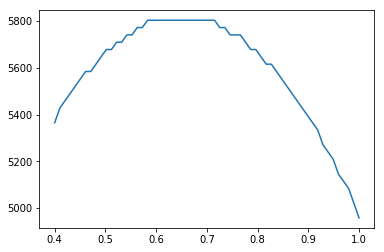

In [16]:
x = np.linspace(0.0001,8000,256)
phi = np.linspace(0.4,1,60)
dist = []
for theta in phi:
    u0 = np.array([          
        [v0*np.cos(theta)],    #u
        [np.tan(theta)],       #gamma
        [0.0],                 #y
        [0.0]                  #t
        ])
    ans0 = universal_runge_kutta(f, u0, x, butcher, a, b)
    arr = [n[2].item(0)>=0 for n in ans0[0]].index(False)
    dist.append(x[arr-1])
plt.figure()
plt.plot(phi,dist)
max(dist)

D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
D:\Programs\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:680: RuntimeWarning: overflow encountered in double_scalars
  y = y * x + p[i]
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in power
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in cdouble_scalars
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value

5823.874782583171

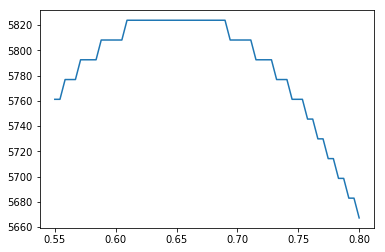

In [18]:
x = np.linspace(0.0001,8000,512)
phi = np.linspace(0.55,0.8,60)
dist = []
for theta in phi:
    u0 = np.array([          
        [v0*np.cos(theta)],    #u
        [np.tan(theta)],       #gamma
        [0.0],                 #y
        [0.0]                  #t
        ])
    ans0 = universal_runge_kutta(f, u0, x, butcher, a, b)
    arr = [n[2].item(0)>=0 for n in ans0[0]].index(False)
    dist.append(x[arr-1])
plt.figure()
plt.plot(phi,dist)
max(dist)